# Étude de l'effet du saut de propriétés à l'interface sur la conservation de l'énergie

In [1]:
import sys
import itertools
import os

lib_path = os.path.realpath(os.path.join(os.getcwd(), '..'))
if lib_path not in sys.path:
    sys.path = [lib_path] + sys.path
savefig_path = '/home/as259691/Documents/rapports/article_JCP/figures/'
save_fig = False

In [2]:
from src.main import *
from src.plot_fields import *

%matplotlib notebook
rc('figure', figsize=(10,5))
rc('figure', dpi=100)
rc('font', size=18)
rc('legend', fontsize=16)
rc('figure', max_open_warning=80)

In [3]:
n_max = 10**6

## Paramètres de la simulation

Ici on va construire une grille de paramètres.

La résolution se fait à chaque fois en QUICK avec Euler explicite en temps.

In [4]:
# d = 6./100*Delta/2.
Delta = 0.02
alpha = 0.06
n_bulles = 4.
rho_cp1 = 70278.
# rho_cp2 = 702780.
lda1 = 5.5*10**-2
# lda2 = 15.5
kappa0 = lda1 / rho_cp1
Vtot = 0.005**2*Delta/n_bulles

n_lim = 10**6
t_fin = 0.2

class Problem_prop(Problem):
    def __init__(self, T0, markers=None, num_prop=None, phy_prop=None):
        super().__init__(T0, markers=markers, num_prop=num_prop, phy_prop=phy_prop)
        
    @property
    def name(self):
        return r'$\frac{\lambda_l}{\lambda_v} = %.2g,\ \frac{{\rho C_p}_l}{{\rho C_p}_v} = %.2g,\ \frac{\lambda_l}{{\rho C_p}_l} = %.2g$' % (self.phy_prop.lda1/self.phy_prop.lda2, self.phy_prop.rho_cp1/self.phy_prop.rho_cp2, self.phy_prop.lda1/self.phy_prop.rho_cp1)

On a les 3 nombres adimensionnés suivants à faire évoluer :
- le rapport des capacités thermiques massique $\frac{{\rho C_p}_l}{{\rho C_p}_v}$, on va prendre $[0.1, 1, 10, 1000]$
- le rapport des conductivités thermiques $\frac{\lambda_l}{\lambda_v}$, on va prendre la même liste
- le coefficient $\frac{\kappa}{\kappa_0}$ avec $\kappa = \frac{\lambda_l}{{\rho C_p}_l}$, on va prendre $[0.1, 1, 10]$
- le dernier paramètre n'est pas pertinent a priori dans la résolution de l'équation. On le fera varier par rapport à $\lambda_{1_0}$ pour vérifier qu'il n'en pas influent. 

In [5]:
rapp_lda = [0.1, 1., 10.]
rapp_rhocp = rapp_lda
rapp_kappa = [0.1, 1., 10.]

lda_10 = lda1
kappa_0 = lda1 / rho_cp1

def compute_for_rapp(rapp):
    lda_l = lda_10
    lda_v = lda_l / rapp[0]
    rho_cp_l = lda_l/(kappa_0 * rapp[2])
    rho_cp_v = rho_cp_l / rapp[1]
    plot = rapp[3]
    ax = rapp[4]
    phy_prop = PhysicalProperties(Delta=Delta/n_bulles, v=0.2, dS=0.005**2,
                                  lda1=lda_l, lda2=lda_v, rho_cp1=rho_cp_l, rho_cp2=rho_cp_v, diff=1.,
                                  alpha=alpha*n_bulles, a_i=357.)
    num_prop = NumericalProperties(dx=3.9*10**-5, schema='quick', time_scheme='rk3', phy_prop=phy_prop, cfl=0.5, fo=0.5)
    markers = Bulles(n_bulle=1, phy_prop=phy_prop)
    prob = Problem_prop(get_T_creneau, num_prop=num_prop, phy_prop=phy_prop, markers=markers)
    E0 = prob.energy
    print('==========================')
    t, e = prob.timestep(t_fin=t_fin, n=min(n_max, n_lim), number_of_plots=1, debug=None, plotter=plot)
    l = ax.plot(t, e/E0*100, label=prob.name)
    n = len(e)
    i0 = int(n/5)
    dedt_adim = (e[-1] - e[i0]) / (t[-1] - t[i0]) * prob.dt / E0  # on a mult
    # par Dt / rho_cp_l T_l V
    print('dE*/dt* = %g' % dedt_adim)
    return plot

<IPython.core.display.Javascript object>


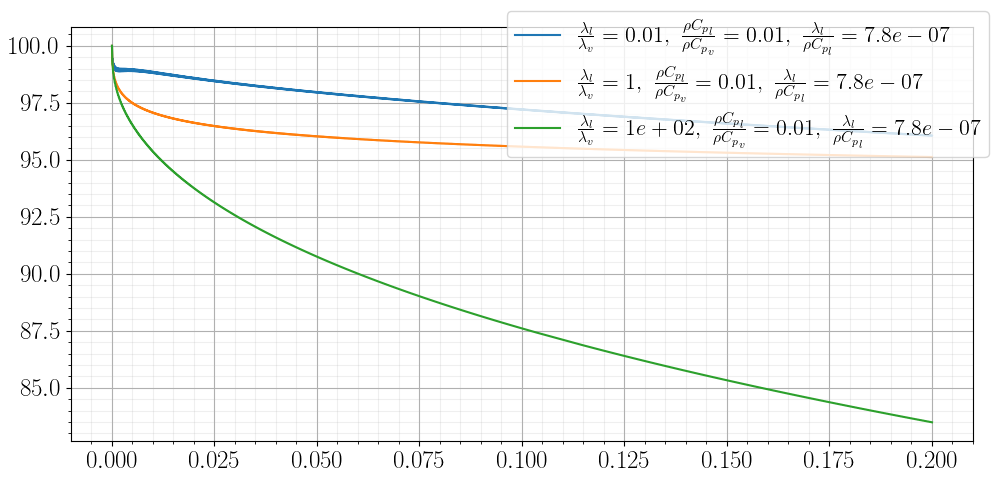

dt fourier
9.748701615767045e-06


<IPython.core.display.Javascript object>


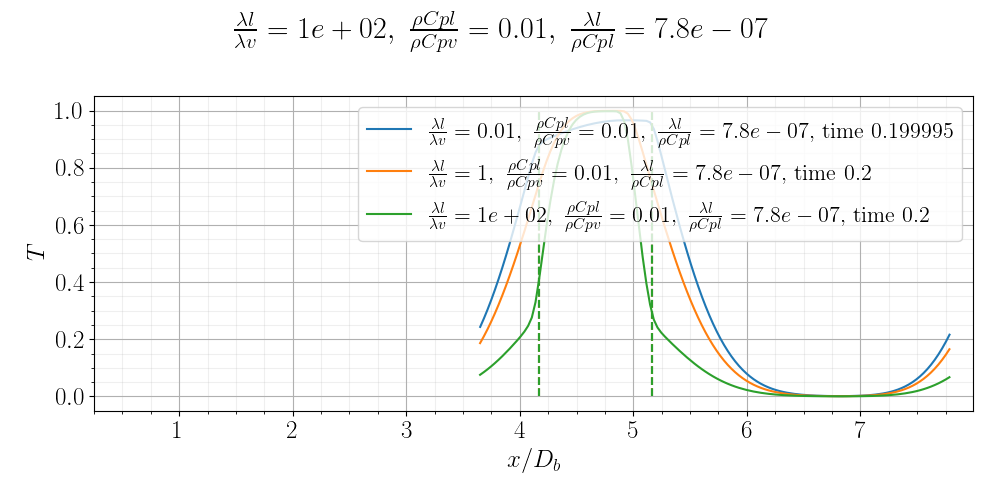

dE*/dt* = -1.27445e-06
dt cfl
9.765624999999999e-05
dE*/dt* = -6.38202e-06
dt cfl
9.765624999999999e-05
dE*/dt* = -4.94638e-05


In [6]:
fig1,ax1 = plt.subplots(1)
plot = Plotter('decale')
prod_lda = itertools.product(rapp_lda, [0.1], [1.], [plot], [ax1])

list(map(compute_for_rapp, prod_lda))

le = fig1.legend()
ax1.grid(b=True, which='major')
ax1.minorticks_on()
ax1.grid(b=True, which='minor', alpha=0.2)
fig1.tight_layout()

<IPython.core.display.Javascript object>


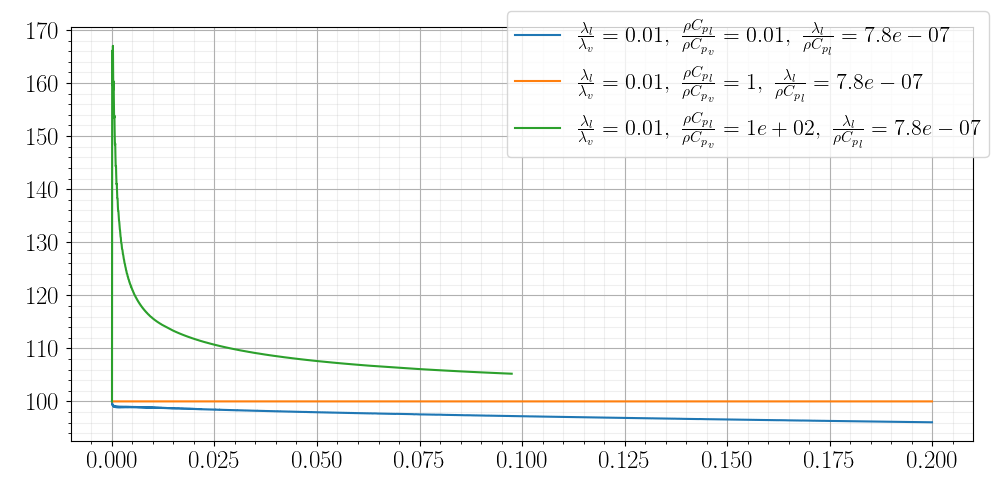

dt fourier
9.748701615767045e-06


<IPython.core.display.Javascript object>


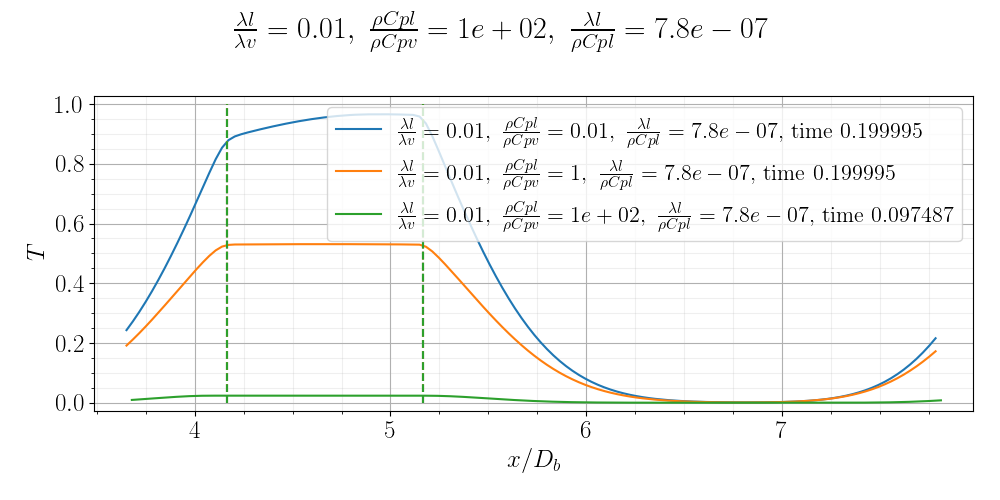

dE*/dt* = -1.27445e-06
dt fourier
9.748701615767045e-06
dE*/dt* = -6.26669e-20
dt fourier
9.748701615767045e-08
dE*/dt* = -8.38982e-08


In [7]:
fig2,ax2 = plt.subplots(1)
plot2 = Plotter('decale')
prod_rhocp = itertools.product([0.1], rapp_rhocp, [1.], [plot2], [ax2])
    
list(map(compute_for_rapp, prod_rhocp))

le = fig2.legend()
ax2.grid(b=True, which='major')
ax2.minorticks_on()
ax2.grid(b=True, which='minor', alpha=0.2)
fig2.tight_layout()

<IPython.core.display.Javascript object>


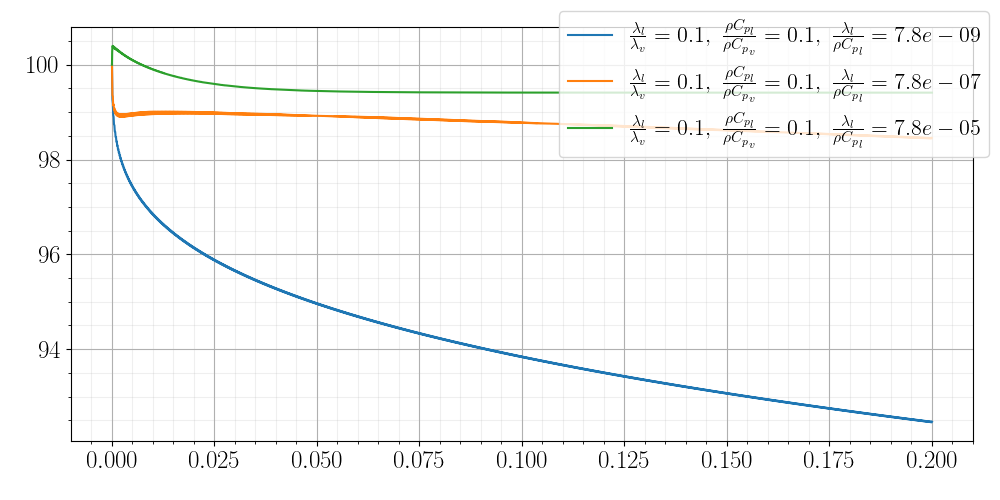

dt cfl
9.765624999999999e-05


<IPython.core.display.Javascript object>


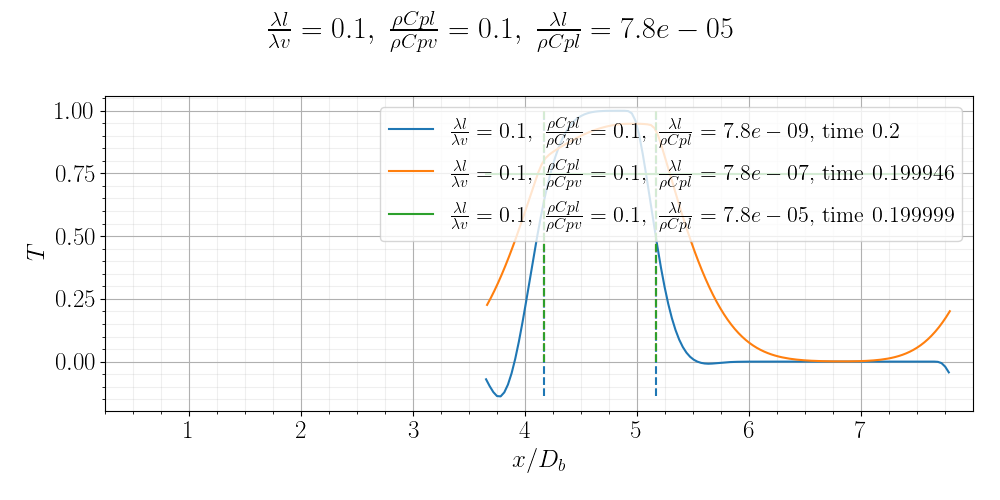

dE*/dt* = -1.70893e-05
dt fourier
9.748701615767048e-05
dE*/dt* = -3.05388e-06
dt fourier
9.748701615767048e-07
dE*/dt* = -4.16435e-09


In [9]:
fig3,ax3 = plt.subplots(1)
plot3 = Plotter('decale')
prod_kappa = itertools.product([0.1], [0.1], rapp_kappa, [plot3], [ax3])
    
list(map(compute_for_rapp, prod_kappa))

le = fig3.legend()
ax3.grid(b=True, which='major')
ax3.minorticks_on()
ax3.grid(b=True, which='minor', alpha=0.2)
fig3.tight_layout()